In [1]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# project_dir = "/codespace/braintypicality"
# sys.path.append(project_dir)

In [2]:
import skimage
import glob
import math
import torch
import ants
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from matplotlib import ticker
import matplotlib as mpl
import matplotlib.colors as mcolors


from functools import partial

import skimage.filters as skf
# from scipy.stats import percentileofscore
# from numba import jit
# from utils import get_percentile_tensor

from sade.metrics import erode_brain_masks
from sade.datasets.loaders import get_dataloaders

[1713980271.447771] [fa79a04240ba:13100:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device


2024-04-24 17:37:55.160952: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 17:37:55.163208: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 17:37:55.196956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/tmp/ipykernel_13100/3641958452.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



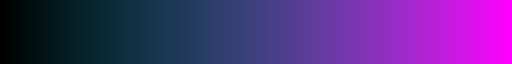

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Get the "cool" colormap
cool = plt.cm.get_cmap('cool')

# Create a new colormap by blending black at the lower end
n = 256  # Number of color steps
colors = np.zeros((n, 4))
colors[:, 3] = 1  # Set alpha to 1

# Linear interpolation from black to the original "cool" colormap
for i in range(n):
    alpha = i / (n - 1)
    colors[i, :3] = (1 - alpha) * np.array([0, 0, 0]) + alpha * np.array(cool(i / (n - 1))[:3])

# Create the new colormap
cool_black = LinearSegmentedColormap.from_list('cool_black', colors)
cool_black

In [120]:
from sade.configs.flows import ve_flow_config as configs
config = configs.get_config()
config.msma.denoise=False
config.msma.schedule = "geometric"
config.model.learnable_embedding=True
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable"
unscale = lambda x: (x+1)/2

### Load the data

In [9]:
flow_path = '/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/flow//psz3-globalpsz17-nb20-lr0.0003-bs32-np1024-kimg300_smin1e-2_smax0.8/eval/ckpt_9240/'
%ls -ailh $flow_path/

total 6.4G
21475109661 drwxr-xr-x. 2 amahmood root 4.0K Mar  6 20:50 ./
17181880790 drwxr-xr-x. 3 amahmood root   30 Mar  4 19:32 ../
21476111878 -rw-r--r--. 1 amahmood root 2.0G Mar  5 22:44 abcd-test_lesion_load_20-enhanced_results.npz
21476853442 -rw-r--r--. 1 amahmood root  14K Mar  5 23:23 abcd-test_lesion_load_20-enhanced_seg_eval.csv
21476853440 -rw-r--r--. 1 amahmood root 779K Mar  5 23:22 abcd-test_lesion_load_20-enhanced_segs.npz
21476853460 -rw-r--r--. 1 amahmood root 2.0G Mar  6 20:52 abcd-val_lesion_load_20_results.npz
21476853444 -rw-r--r--. 1 amahmood root 823M Mar  6 00:10 ibis-hr-inlier_ibis-ds-sa_results.npz
21476853450 -rw-r--r--. 1 amahmood root 903M Mar 11 18:34 ibis-inlier_ibis-asd_results.npz
21476853452 -rw-r--r--. 1 amahmood root 737M Mar 11 19:31 ibis-inlier_ibis-atypical_results.npz


In [10]:
config.data.dataset = "ABCD"
config.eval.experiment.train = "abcd-val"
config.eval.experiment.inlier = "abcd-test"
config.eval.experiment.ood = "lesion_load_20-enhanced"
config.data

cache_rate: 0.0
dataset: ABCD
dir_path: /DATA/Users/amahmood/braintyp/processed_v2/
image_size: !!python/tuple
- 96
- 112
- 80
num_channels: 2
spacing_pix_dim: 2.0
splits_dir: /codespace/sade/sade/datasets/brains/

In [11]:
experiment = config.eval.experiment
experiment_name = f"{experiment.inlier}_{experiment.ood}"
experiment_name

'abcd-test_lesion_load_20-enhanced'

In [12]:
%%time
data = np.load(f"{flow_path}/{experiment_name}_results.npz", allow_pickle=True)
# x_inlier_scores = data["inliers"]
x_ood_scores = data["ood"]

CPU times: user 15.2 s, sys: 2.33 s, total: 17.6 s
Wall time: 28 s


In [13]:
x_ood_scores.shape

(165, 96, 112, 80)

In [14]:
%%time
gradcam_path = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/msma/gradcam/relu/"
data = np.load(f"{gradcam_path}/{experiment_name}_results.npz", allow_pickle=True)
# x_inlier_gradcam = data["inliers"]
x_ood_gradcam = data["ood"]

CPU times: user 7.63 s, sys: 1.15 s, total: 8.77 s
Wall time: 14 s


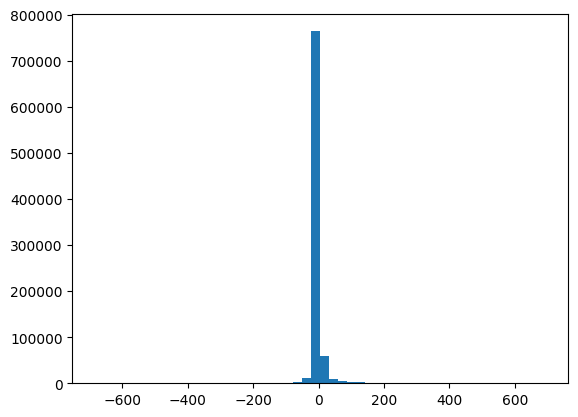

In [18]:
plt.hist(x_ood_gradcam[0].ravel(), bins=50);

## Computing brain masks

In [165]:
%%time
config.eval.experiment.ood = "lesion_load_20"
config.eval.batch_size = 4
config.device = torch.device("cpu")

(_, inlier_ds, ood_ds), _ = get_dataloaders(
    config, evaluation=True, ood_eval=True,
)

x_inlier = []
for x in inlier_ds:
    x_inlier.append(x["image"])
    break
    
x_inlier = torch.cat(x_inlier)

x_ood = []
x_ood_labels = []
for x in ood_ds:
    x_ood.append(x["image"])
    x_ood_labels.append(x["label"])

x_ood = torch.cat(x_ood)
x_ood_labels = torch.cat(x_ood_labels)

Train Samples: 165
CPU times: user 925 ms, sys: 3.01 s, total: 3.93 s
Wall time: 33.4 s


In [121]:
# x_ood = unscale(x_ood)

In [20]:
%%time
inlier_brain_masks = (x_inlier != -1.0).sum(dim=1).bool()
ood_brain_masks = (x_ood != -1.0).sum(dim=1).bool()

CPU times: user 1.81 s, sys: 2.18 s, total: 3.99 s
Wall time: 645 ms


In [21]:
%%time
eroded_inlier_brain_masks = erode_brain_masks(inlier_brain_masks)
eroded_ood_brain_masks = erode_brain_masks(ood_brain_masks)

CPU times: user 15 s, sys: 583 ms, total: 15.5 s
Wall time: 14.7 s


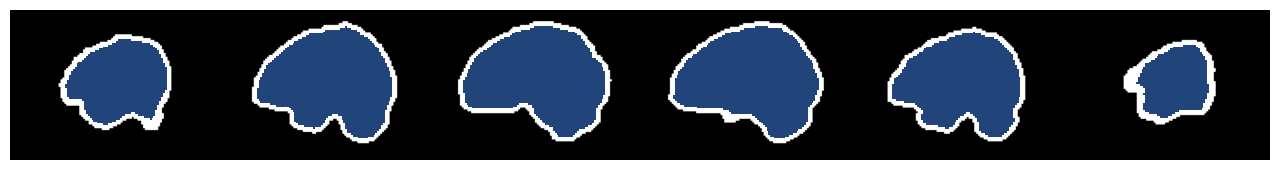

In [22]:
mask = ants.from_numpy((ood_brain_masks[0]).float().numpy())
eroded_mask = ants.from_numpy(eroded_ood_brain_masks[0].astype(float))
mask.plot(overlay=eroded_mask, overlay_cmap="Blues", nslices=6)

In [28]:
# %%time
# brain_masks = (x_ood[:3] == -1.0).sum(dim=1).bool()
brain_masked_ood_scores = x_ood_scores.copy()
brain_masked_ood_scores = brain_masked_ood_scores * ood_brain_masks + x_inlier_scores.min() * (~ood_brain_masks)
eroded_masked_ood_scores =  x_ood_scores.copy() * eroded_ood_brain_masks + x_inlier_scores.min() * (1 - eroded_ood_brain_masks)

brain_masked_ood_scores.shape, eroded_masked_ood_scores.shape

((165, 96, 112, 80), (165, 96, 112, 80))

#### Getting prediciton labels and masking them

In [24]:
pred_labels = x_ood_labels.sum(1).cpu().numpy() > 0
pred_labels_masked = (pred_labels * eroded_ood_brain_masks).astype(float)

In [ ]:
ants.plot(x_img, overlay=x_label_img, nslices=6, overlay_cmap=cool_black, overlay_alpha=.6,
              cbar=True, cbar_vertical=False, cmap="summer", scale=(0.5, 0.9999)
    )

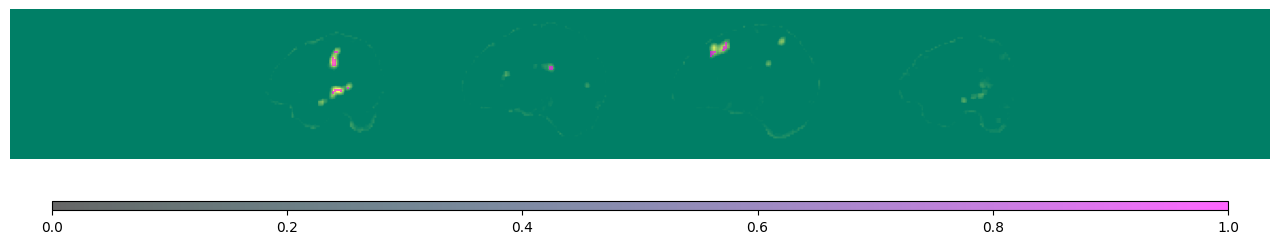

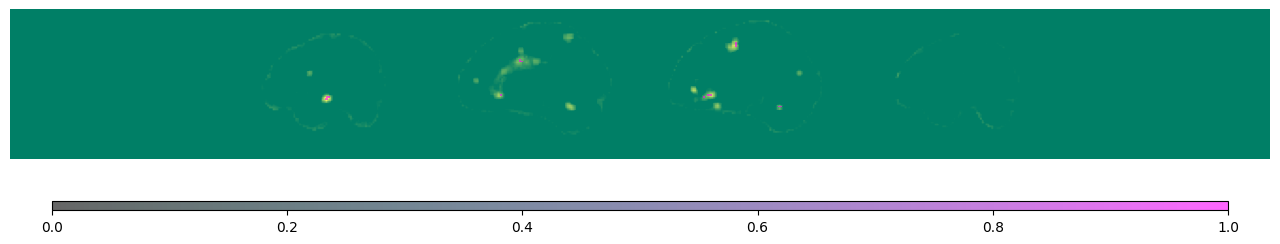

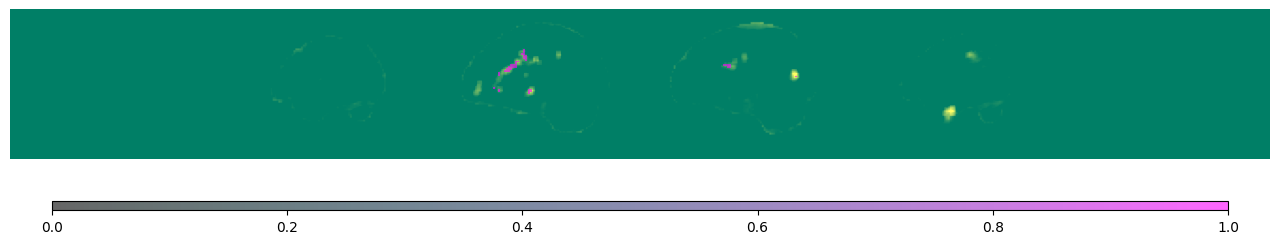

In [29]:
for idx in range(3):
#     x_ood_p = torch_pscore(x_ood_scores[idx], reference_scores)[0]
#     x_ood_p *= eroded_ood_brain_masks[idx]
#     x_ood_p = np.clip(x_ood_p, 90, 100)
    x_ood_p = x_ood_scores[idx]
    x_ood_p *= eroded_ood_brain_masks[idx]
    
    x_ood_p = x_ood_p - x_ood_p.min()
    x_ood_p = x_ood_p / x_ood_p.max()
    
    x_label = pred_labels_masked[idx]
    x_img = ants.from_numpy(x_ood_p)
    x_label_img = ants.from_numpy(x_label)

    ants.plot(x_img, overlay=x_label_img, nslices=6, overlay_cmap=cool_black, overlay_alpha=.6,
              cbar=True, cbar_vertical=False, cmap="summer", scale=(0.5, 0.9999)
    )

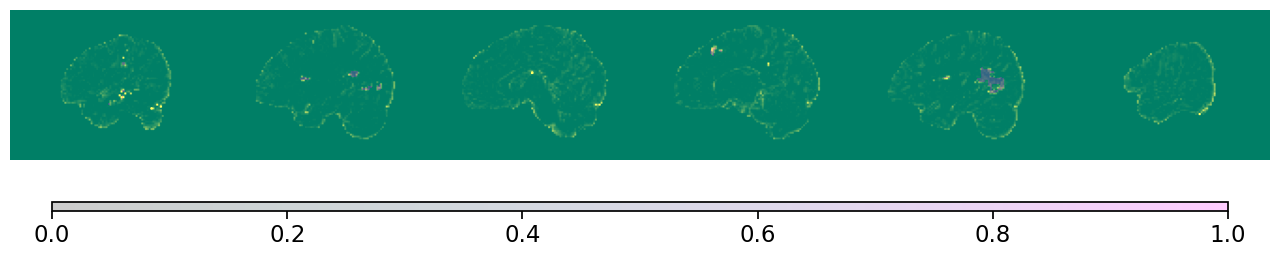

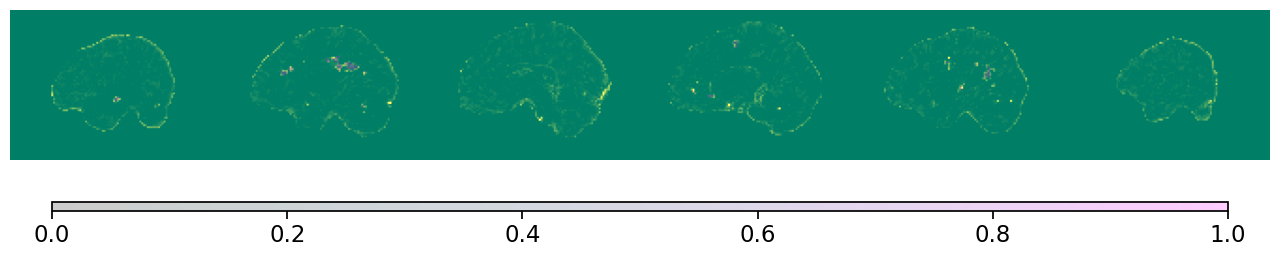

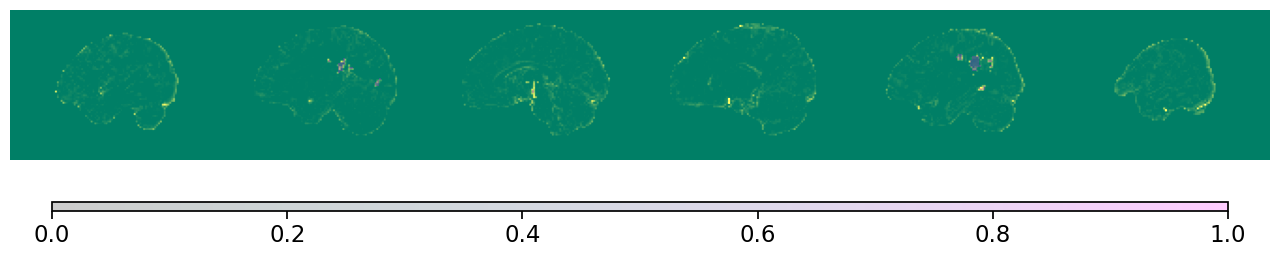

In [266]:
for idx in range(3):
    x_ood_p = np.abs(x_ood_gradcam[idx])
    x_ood_p *= eroded_ood_brain_masks[idx]
    
    x_ood_p = x_ood_p - x_ood_p.min()
    x_ood_p = x_ood_p / x_ood_p.max()
    
    x_label = pred_labels_masked[idx]
    x_img = ants.from_numpy(x_ood_p)
    x_label_img = ants.from_numpy(x_label)

    ants.plot(x_img, overlay=x_label_img, nslices=6, overlay_cmap=cool_black, overlay_alpha=.2,
              cbar=True, cbar_vertical=False, cmap="summer", scale=(0.5, 0.999)
    )

In [265]:
# nidxs = np.arange(0,12,2)

# for idx in range(2):
#     x_img = x_ood[idx,1] * ood_brain_masks[idx]
#     x_img = ants.from_numpy(x_img.numpy())
#     x_label_img = ants.from_numpy(pred_labels_masked[idx].astype(float))
    
#     largest_lesion_slices = pred_labels_masked[idx].sum(axis=(0,1)).argsort()[::-1]
#     lesion_slices = np.where(pred_labels_masked[idx].sum(axis=(0,1)) > 50)[0]
    
#     ants.plot(x_img, overlay=x_label_img, slices=lesion_slices[nidxs], overlay_cmap="cool",
#               cbar=False, cbar_vertical=False, scale=(0.001, 0.9999),  overlay_alpha=0.5, axis=2
#     )
    
#     pred = eroded_masked_ood_scores[idx]
#     score_hist = pred[pred.nonzero()]
#     min_intensity, max_intensity = np.quantile(score_hist, 0.95), np.quantile(score_hist, 0.9999)
#     pred = np.clip(pred, min_intensity, max_intensity)
#     x_img = ants.from_numpy(pred)
    
#     x_img = (x_img - min_intensity) / (max_intensity - min_intensity)
#     x_img *= eroded_ood_brain_masks[idx].astype(float)
#     ants.plot(x_img, slices=lesion_slices[nidxs],
#               cbar=True, cbar_vertical=False, cmap="summer", scale=(0.8, 0.9999), axis=2
#     )

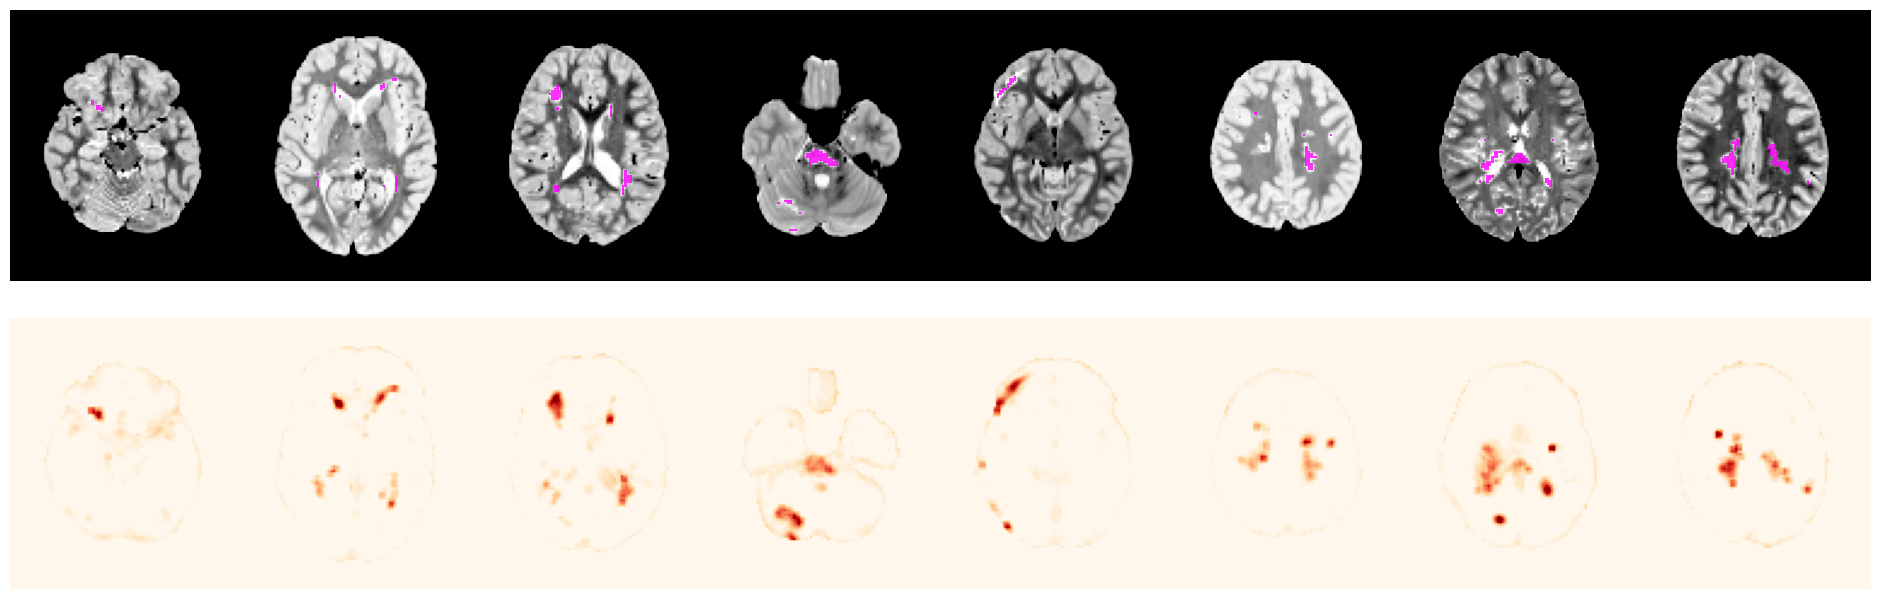

In [264]:
sns.set_context("notebook", font_scale=1.5, rc={"axes.grid": False, "axes.titlesize":22, 'axes.labelweight':'bold'})
np.random.seed(42)

nrows, ncols = 2, 8
nidxs = np.arange(0,12,2)
alpha=0.8

fig, axs = plt.subplots(nrows, ncols, figsize=(24, 8),
                        gridspec_kw={'wspace': 0, 'hspace': 0,
#                                                'left':0.5 / (ncols + 1), 'right':1 - 0.5 / (ncols + 1),
#                                               'top':1.0 - 0.5 / (nrows + 1), 'bottom':0.5 / (nrows + 1),
                                              })
for idx in range(ncols):
    sampleidx = np.random.randint(len(x_ood))
    
    ###### Input image ########
    x_img = x_ood[sampleidx,1].numpy() * ood_brain_masks[sampleidx]
    x_label_img = pred_labels_masked[sampleidx].astype(float)
    vmin, vmax = np.quantile(x_img, q=(0.03, 0.999))
    
#     lesion_slices = np.where(x_label_img.sum(axis=(0,1)) > 50)[0]
    randidx = np.random.randint(0,20)
    largest_lesion_slice = x_label_img.sum(axis=(0,1)).argsort()[::-1][randidx]
    
    image = x_img[:,:,largest_lesion_slice].T
    overlay = x_label_img[:,:,largest_lesion_slice].T

    image[image == 0.0] = -1
    axs[0,idx].imshow(image, cmap="Greys_r", vmin=vmin, vmax=vmax)
    ov_arr = np.ma.masked_where(overlay == 0, overlay)
    axs[0,idx].imshow(ov_arr, cmap="cool", vmin=0, alpha=alpha)
    ###############################
    
    for axidx in range(1, nrows):
        pred = eroded_masked_ood_scores[sampleidx]
        score_hist = pred[pred.nonzero()]
        min_intensity, max_intensity = np.quantile(score_hist, 0.95), np.quantile(score_hist, 0.9999)
        pred = np.clip(pred, min_intensity, max_intensity)

        axs[axidx, idx].imshow(pred[:,:,largest_lesion_slice].T, cmap='OrRd')
        
for ax in axs.flat:
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])